In [30]:
%run basic_strategies.ipynb
%run evolution.ipynb
%run multi_player.ipynb
%run additional_strategies.ipynb

import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import matplotlib as mpl
import numpy as np
from numpy import std, mean, array



Let's implement an algorithm composed by many cycles of round robin tournament. In the whole run the total population is fixed but the number of players in each class in a cycle depends on the scores that they obteined in the previos cycle with a proportional law. 
The function init_classed make the initial list of players:

In [7]:
def init_classed(N):
    pl=[]
    for i in range(N//6):
        pl.append(bad_guy)
        pl.append(nice_guy)
        pl.append(mn_guy)
        pl.append(avg_guy) 
        pl.append(mb_guy)
        pl.append(tt_guy)
        
    while len(pl) < N:
        pl.append(avg_guy)
        
    return pl

The function repeated performs the run composed by 'cyc' number of cycles and stop it if the scores in output are the same (with a tollerance of 0.001%) 20 times in a row. 
The function select is called to sort the results and to update the population with the following rule:
$$C^{n+1}_i = C^n_i + C^n_i \frac{S^n_i - \mu^n}{\mu^n}$$ where n is the n-th cycle, $C_i$ is the i-th (i=1...N) class and $\mu^n = \Sigma_i \frac{C^n_i S^n_i}{N}$. 
Here a simple proof of the fact that, with this updating rule, the population does not change during the run:
$\Sigma_i C^{n+1}_i = \Sigma_i [ C^n_i + C^n_i \frac{(S^n_i - \Sigma_i \frac{C^n_i S^n_i}{N})}{\mu^n} ] = \Sigma_i  C^n_i + \Sigma_i\frac{C^n_i S^n_i}{\mu^n} - \frac{N}{\mu^n}\Sigma_i\frac{C^n_i S^n_i}{N} - = \Sigma_i  C^n_i $

So classes with better scores reproduce faster and the population of the ones with performance under the avarage is decreased.

In [8]:
def repeated(N, it, cyc, classed=True):
    if classed:
        pl=init_classed(N)
    else:
        pl = init(N)
    
    hist=[]
    scores = round_robin(pl, it)
    
    hist.append((pl, scores)) #aggiunta da electro
    stop_counter=0          #
    
    for i in range(cyc-1):
        if classed:
            pl = select(pl, scores)
            #print("selecting")
        else:
            pl = evolve(pl, scores)
            #print("evolving")
        
        scores = round_robin(pl, it)
        hist.append((pl, scores))
        
        
        if ( np.allclose(scores, hist[i][1], atol=0.0001*max(scores)) ):#aggiunta da electro
            stop_counter+=1
        else:
            stop_counter=0
            
        if stop_counter==20:
            break
    
    if classed:
        pl=select(pl, scores)
    else:
        pl=evolve(pl, scores)
        
    scores = round_robin(pl, it)
    
    return hist



The function stats computes the means and the standard deviations of the the scores of each class in the last 20 cycles, where we supposed that a stable solution is found. In addition it generates two plots to show the trend of both number(counts) and scores of the classes.

In [9]:
def stats(hist):
    
    scores=[]
    counts=[]
    cl, sc, nums = select(hist[0][0], hist[0][1], True)
    names = [str(c) for c in cl]
    
    scores.append(sc)
    counts.append(nums)
    
    for i in range(1,len(hist)):
        cl, sc, nums = select(hist[i][0], hist[i][1], True)
        new_names = [str(c) for c in cl]
        
        sc_ord = []
        num_ord = []
    
        for j in range(len(names)):
            
            for k in range(len(new_names)):
                if new_names[k] == names[j]:
                        sc_ord.append(sc[k])
                        num_ord.append(nums[k])
                        break
            else:
                sc_ord.append(0)
                num_ord.append(0)
                
        scores.append(sc_ord)
        counts.append(num_ord)
    
    scores = np.array(scores).T
    counts = np.array(counts).T
   
    means = []
    dev = []
    
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
    for j in range(len(names)):
        means.append( np.mean(scores[j][-20:]) )
        dev.append( np.std(scores[j][-20:]) )
        ax[0].plot(np.arange(0,len(hist)),scores[j], label=names[j])
        ax[1].plot(np.arange(0,len(hist)),counts[j], label=names[j])
        ax[0].legend()
        
        #print(cl[j][1],means[j],dev[j])
    
    return cl, means, dev


here an example where all the classes of player are in the simulation at first in equal number:

In [10]:
N=120
it=100
cyc=100
classed=True

hist = repeated(N, it, cyc, classed)


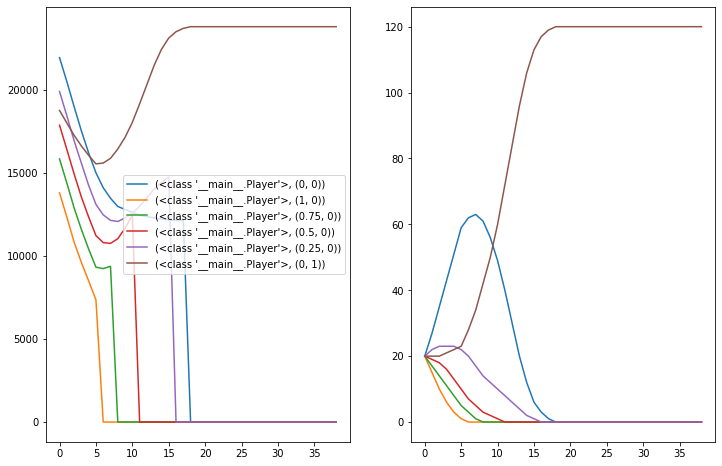

In [11]:
cl, means, dev = stats(hist) 

It is interesting to note that at firts all the classes decrease thier avarage score:
it happens beacuse the class (0,0) evil_guy is the one with the highest score in the first 5 cycles and its population increase immediately and this makes all the other scores lower.
The only class able of competing with the evil_guy is the tit for tat which, thanks to its cooperative behavior with players of the same species and a cheating behavior with the evil ones: that allow it to earn more points than a class that always betrays


Here another important example where there are only 5 tt_guys and the remaining 95 are all bad_guys.

In [12]:
def init_classed(N):
    pl=[]
    for i in range(N-5):
        pl.append(bad_guy)
        
    while len(pl) < N:
        pl.append(tt_guy)
        
    return pl

N=100
it=100
cyc=100
classed=True

hist = repeated(N, it, cyc, classed)


[0.0, 19800.0]


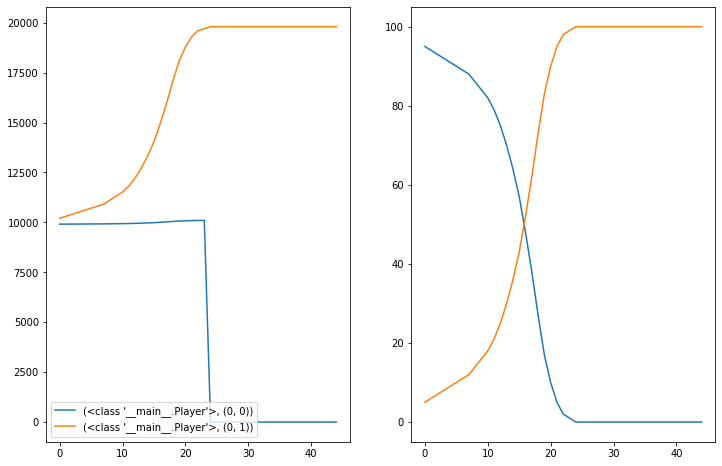

In [13]:
cl, means, dev = stats(hist) 
print(means)

Even with a huge difference between the number of the two players, thanks to an avarage score at first a little better, the tt_guy in a few cycles takes over the evil_guy which estinguishes. 
Furthermore tt class is very difficult to be invaded beacuse of its retaliating behavior: any other class get a lower score with tt_guy than tt_guy with himself

In [37]:
def init_classed(N):
    pl=[]
    for i in range(N//7):
        pl.append(TF2T())
        pl.append(SusTFT())
        pl.append(Majority(True))
        pl.append(Majority(False))
        pl.append(HTFT())
        pl.append(tt_guy)
        pl.append(avg_guy)

    while len(pl) < N:
        pl.append(avg_guy)
        
    return pl

N=100
it=100
cyc=100
classed=True

hist = repeated(N, it, cyc, classed)

[19800.0, 19800.0, 19800.0, 19800.0, 19800.0, 19800.0, 0.0]


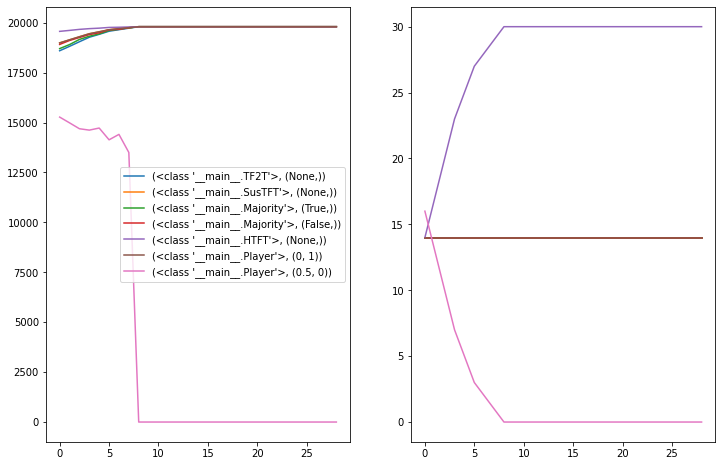

In [38]:
cl, means, dev = stats(hist) 
print(means)

In [ ]:
fig, ax = plt.subplots(1,2)
cl, sc, nums = select(hist[0][0], hist[0][1], True)
col=[i for i in range(len(sc))]
names = [str(c) for c in cl]
b = ax[0].bar(names, sc)
b[0].set_color('r')
b[0].set_color('g')
b2 = ax[1].bar(names, nums)
b2[0].set_color('r')
b2[0].set_color('g')
ax[0].set_xticks('')
ax[1].set_xticks('')
fig.legend(handles=b.get_children(), labels=names)

def animate(i):

    cl, sc, nums = select(hist[i][0], hist[i][1], True)
    
    new_names = [str(c) for c in cl]
    sc_ord = []
    num_ord = []
    
    for j in range(len(names)):
        for k in range(len(new_names)):
            if new_names[k] == names[j]:
                    sc_ord.append(sc[k])
                    num_ord.append(nums[k])
                    break
            else:
                sc_ord.append(0)
                num_ord.append(0)
            
        for j in range(len(sc_ord)):
            b.get_children()[j].set_height(sc_ord[j])
            b2.get_children()[j].set_height(num_ord[j])
        
        return *b.get_children(), *b2.get_children()
        
#ani = animation.FuncAnimation(fig, animate, interval=500, blit=True, frames=len(hist))
plt.show()


This code defines a function select that takes in 3 arguments: pl which is an array of Player objects, scores which is an array of scores, and notquite which is a flag that determines whether or not additional information will be returned. The function performs selection based on the mean score of each type of Player and returns a new array of Player objects that has the same length as the input pl array.

If the notquite flag is set to True, the function returns 3 additional arrays: types, sc_by_type, and num_by_type representing the unique types of Player objects in the input pl array, their mean scores, and the number of each type, respectively.

The function works by first separating the Player objects in pl into unique types, calculating the mean score for each type, and sorting the types by their mean score in descending order. Then, the function calculates the number of each type in the new Player array, based on their relative mean scores and the total number of Player objects. Finally, it constructs the new Player array by appending each type in the order determined by the sorting. If the new array is not long enough, it will be padded with additional copies of the type with the highest mean score.

This code defines a function evolve that takes in 3 arguments: pl which is an array of Player objects, scores which is an array of scores, and sigma_cutoff which determines the threshold for survival. The function returns a new array of Player objects that has the same length as the input pl array.

The function works by first selecting the Player objects whose scores are greater than the mean score plus a certain number of standard deviations, as determined by the sigma_cutoff argument. The Player objects are selected based on their scores being above a certain threshold. Then, the function creates a number of duplicates of the selected Player objects, so that the new array is of the same length as the original pl array. The duplicates are created by creating Player objects with the same parameters as the original Player objects. Finally, random perturbations are applied to all Player objects in the new array.